<font size="22"> Exploring the Relationship: Predicting Diabetes Risk through Clinical Trial Data Project Report</font> 

<font size="5"> Group 31: Alton Ho, Ivy Feng, Jasmine Li, Marshal Shuai Zhang</font> 

Introduction:

Diabetes is a widespread health concern, demanding proactive strategies for early detection and intervention. This report explores a practical question: "Can we predict a new patient's likelihood of having diabetes based on blood glucose, BMI, and age?" We aim to cut through the complexity and leverage these common health indicators to build a straightforward model for identifying diabetes risk.

High blood glucose, BMI, and age are known factors linked to diabetes. Our study uses real-world data from diverse individuals and employs statistical analyses and machine learning to uncover patterns. The goal is to develop a tool that clinicians can use for early identification and targeted intervention. 

This report seeks not just to contribute to diabetes research but also to make a real impact in clinical settings, promoting early detection, personalized care, and better outcomes for patients.

Final Question: Is the new patient likely to have diabetes based on their blood glucose, BMI, and age?
The reasoning behind choosing these three parameters will be explained below.

In [1]:
#importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(dplyr) 
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

The data we are using is from kaggle. The columns and their meaning are the following: 
- **Pregnancies** represent the number of times an individual has been pregnant. 
- **Glucose** represents plasma glucose concentration for 2 hours in an oral glucose tolerance test. 
- **Blood Pressure** is ​​Diastolic blood pressure measurement (mm Hg). 
- **Skin thickness** measures the Triceps skin fold thickness (mm).
- **Insulin** indicates 2-Hour serum insulin (mu U/ml). 
- **BMI(Body Mass Index)** gives weight in kg/(height in m)², an indicator of a person’s fitness and health level. 
- **Diabetes pedigree function (DPF)** calculates diabetes likelihood depending on the subject's age and his/her diabetic family history. 
- **Age** is the person’s age. 

We will use Blood Glucose, BMI, and Age as our predictors in the following steps

In [2]:
# Reading the Data from URL
diabetes_data <- read_csv("https://raw.githubusercontent.com/altonho67/dsci-100-2023w1-group-31/main/data/diabetes_2.csv")
#diabetes_data
set.seed(2020)
diabetes_data <- diabetes_data %>%
                 mutate(Outcome = as.factor(Outcome))|>
                 mutate(Outcome = fct_recode(Outcome, "Diabetes" = "1", "None" = "0")) |>
                 mutate_at(c('SkinThickness','Insulin','BloodPressure','Glucose'), ~na_if(., 0)) |>
                 na.omit()                 
head(diabetes_data)
tail(diabetes_data)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,None
0,137,40,35,168,43.1,2.288,33,Diabetes
3,78,50,32,88,31.0,0.248,26,Diabetes
2,197,70,45,543,30.5,0.158,53,Diabetes
1,189,60,23,846,30.1,0.398,59,Diabetes
5,166,72,19,175,25.8,0.587,51,Diabetes


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,121,78,39,74,39.0,0.261,28,None
0,181,88,44,510,43.3,0.222,26,Diabetes
1,128,88,39,110,36.5,1.057,37,Diabetes
2,88,58,26,16,28.4,0.766,22,None
10,101,76,48,180,32.9,0.171,63,None
5,121,72,23,112,26.2,0.245,30,None


In [3]:
#observing the mean for our predictors
diabetes_summary <- diabetes_data |>
                 group_by(Outcome) |>
                 map_df(mean)

diabetes_summary

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.292621,122.6158,70.64631,29.12977,155.8855,33.00204,0.5261196,30.83969,NA


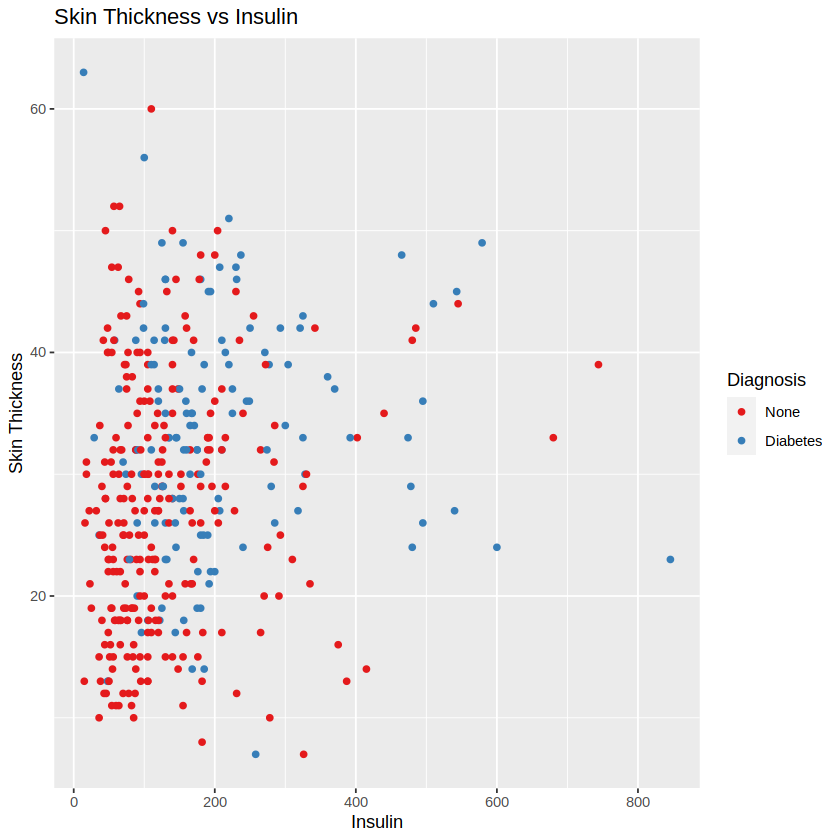

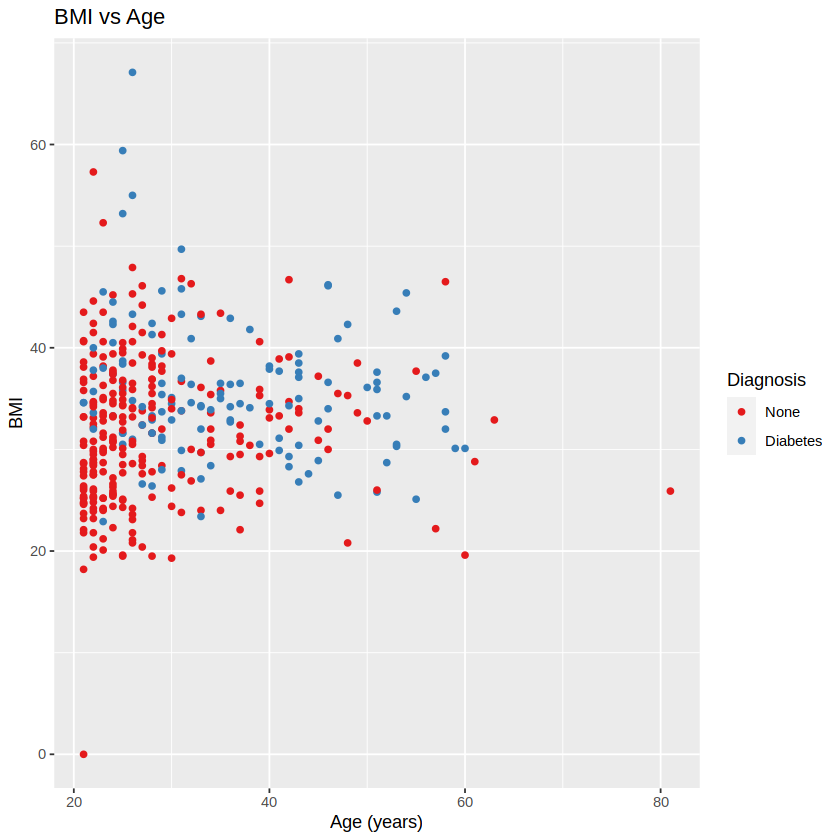

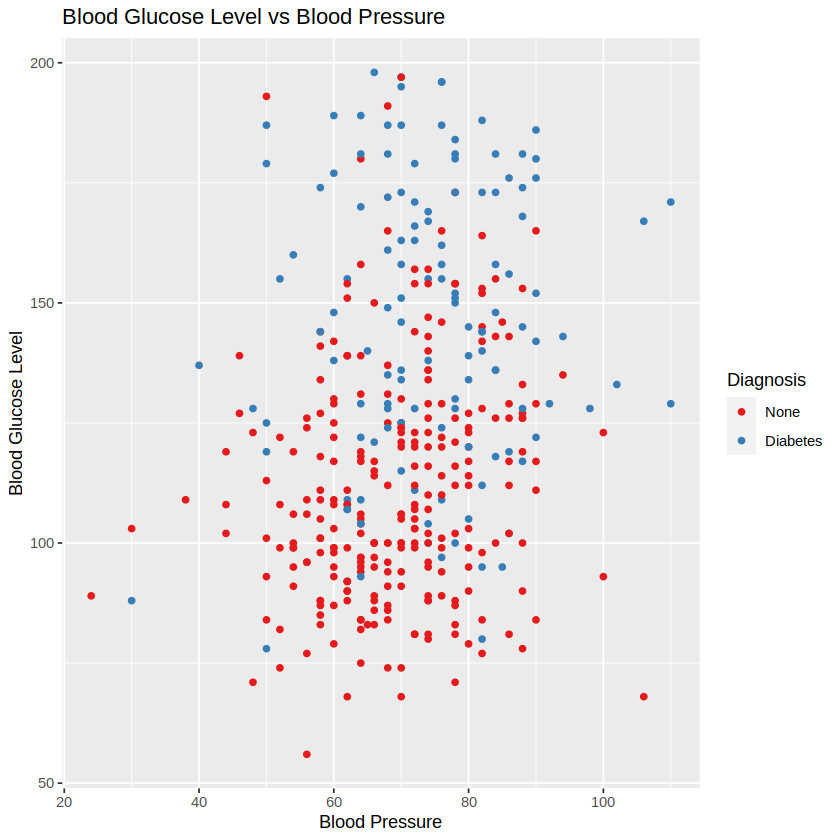

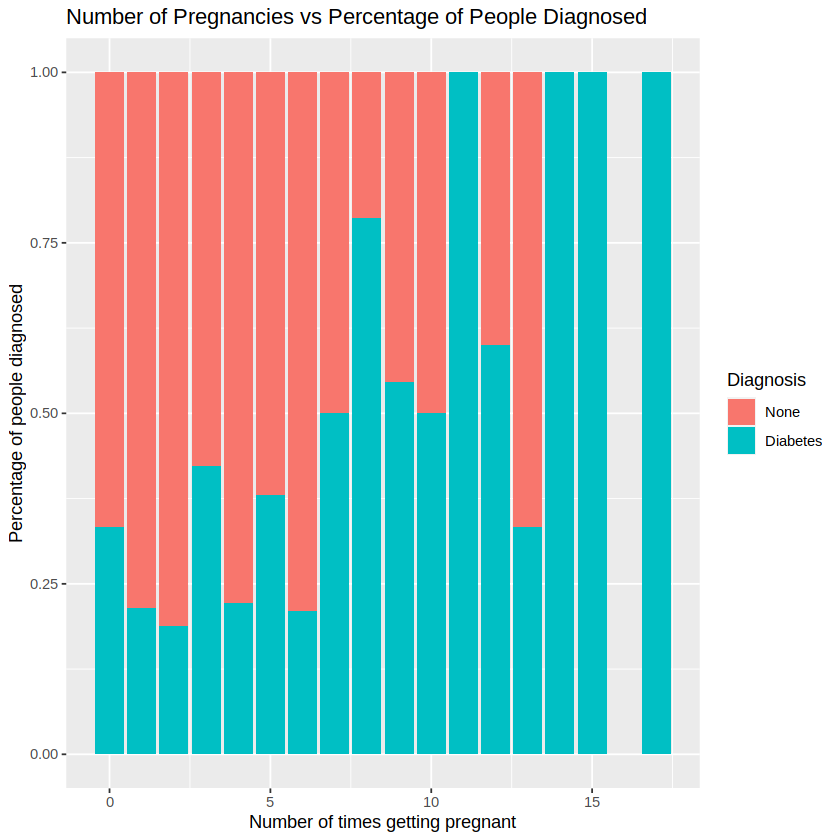

In [4]:
plot1 <- ggplot(diabetes_data, aes(x = Insulin, y = SkinThickness, color = Outcome)) +
                 geom_point() +
                 labs(x = "Insulin", y = "Skin Thickness", color = "Diagnosis") +
                 ggtitle("Skin Thickness vs Insulin") +
                 scale_color_brewer(palette = "Set1")

plot2 <- ggplot(diabetes_data, aes(x = Age, y = BMI, color = Outcome)) +
                 geom_point() +
                 labs(x = "Age (years)", y = "BMI", color = "Diagnosis") +
                 ggtitle("BMI vs Age") +
                 scale_color_brewer(palette = "Set1")

plot3 <- ggplot(diabetes_data, aes(x = BloodPressure, y = Glucose, color = Outcome)) +
                 geom_point() +
                 labs(x = "Blood Pressure", y = "Blood Glucose Level", color = "Diagnosis") +
                 ggtitle("Blood Glucose Level vs Blood Pressure") +
                 scale_color_brewer(palette = "Set1")

plot4 <- ggplot(diabetes_data, aes(x = Pregnancies, fill = Outcome,na.rm=TRUE)) +
                 geom_bar(position="fill") +
                 labs(x = "Number of times getting pregnant", y = "Percentage of people diagnosed", fill = "Diagnosis") +
                 ggtitle("Number of Pregnancies vs Percentage of People Diagnosed") +
                 scale_color_brewer(palette = "Set1")


plot1
plot2
plot3
plot4

Clinical Relevance:

1) Age, BMI, and Glucose are well-established indicators of diabetes risk in clinical settings.
Simplicity and Interpretability:

2) Age, BMI, and Glucose have relatively strong correlation with the target variable according to plot 2 and plot 3. Thus will help us build the most accurate model.

3) These variables offer a straightforward and easily interpretable model.
Existing Research Support:

4) Extensive research supports the significance of Age, BMI, and Glucose in predicting diabetes.
Feasibility:

5) Age, BMI, and Glucose are practical, easily measurable features in real-world scenarios.
Reducing Model Complexity:

6) Focusing on these key predictors helps avoid overfitting and maintains model simplicity.

In [5]:
#splitting the data for the model
diabetes_split <- initial_split(diabetes_data, prop = 3/4, strata = Outcome)
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)



In [6]:
#Standardization
diabetes_recipe <- recipe(Outcome ~ Glucose + BMI + Age, data = diabetes_training)|>
step_scale(all_predictors())|>
step_center(all_predictors())

#Using Knn Model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("classification")

# 5 fold cross validation
diabetes_vfold <- vfold_cv(diabetes_training, v = 5, strata = Outcome)

grid_vals <- tibble(neighbors = c(1:50))

#workflow which binds our nearest_neighbor and the recipe together, also we added our diabetes_vfold and grid_vals
knn_result <- workflow()|>
add_recipe(diabetes_recipe)|>
add_model(knn_tune)|>
tune_grid(resamples = diabetes_vfold, grid = grid_vals)

#filter for the most accurate neighbor amount (k-value)
accuracy <- knn_result|>
collect_metrics()|>
filter(.metric == "accuracy")|>
select(neighbors, mean)|>
arrange(desc(mean))


head(accuracy)

neighbors,mean
<int>,<dbl>
41,0.7826437
42,0.7826437
45,0.7826437
46,0.7826437
39,0.7824138
40,0.7824138



Diabetes Outcome Predictions:

This is the knn neighbor prediction of Diabetes outcome using BMI, Glucose and Age, as these three show a positive relationship with diabetes outcome in the proposal, so I am using them to approximate the outcome. More can be added, such as choosing the best k for knn spec and use vfold.


A k-value of 11 or 12 will give us 78.6% accuracy. A Visualization is below.

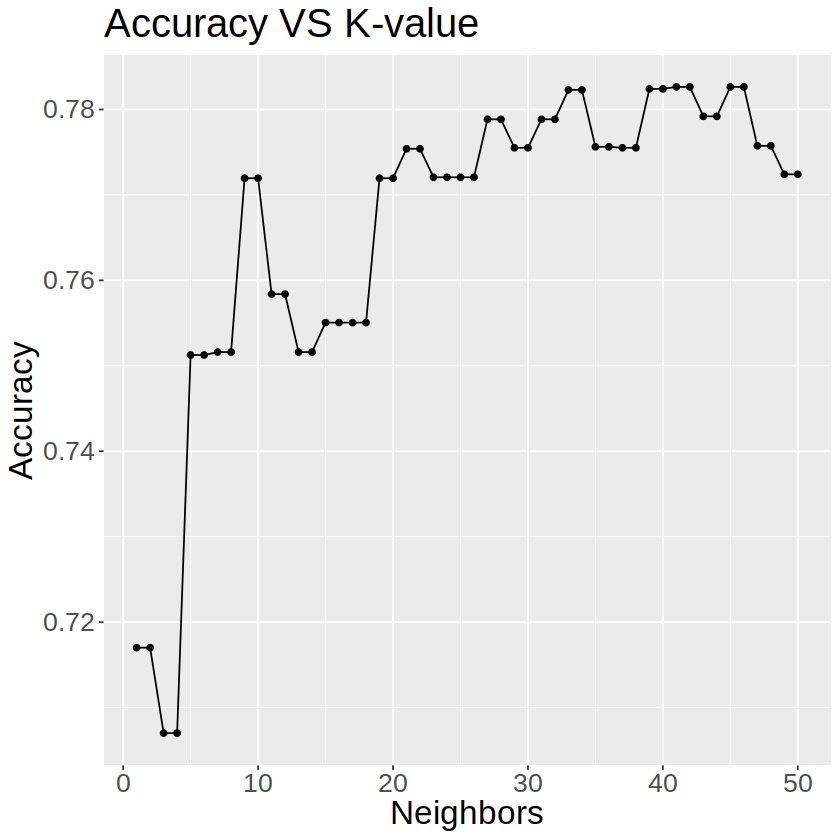

In [7]:
accuracy_vs_k_plot <- accuracy|>
ggplot(aes(x = neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x = "Neighbors", y = "Accuracy", title = "Accuracy VS K-value")+
theme(text = element_text(size = 20))

accuracy_vs_k_plot

In [8]:
set.seed(2020)

diabetes_recipe <- recipe(Outcome ~ Glucose + BMI + Age, data = diabetes_training)|>
step_scale(all_predictors())|>
step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12)|>
set_engine("kknn")|>
set_mode("classification")

diabetes_fit <- workflow()|>
add_recipe(diabetes_recipe)|>
add_model(knn_spec)|>
fit(data = diabetes_training)

diabetes_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(12,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2040816
Best kernel: rectangular
Best k: 12

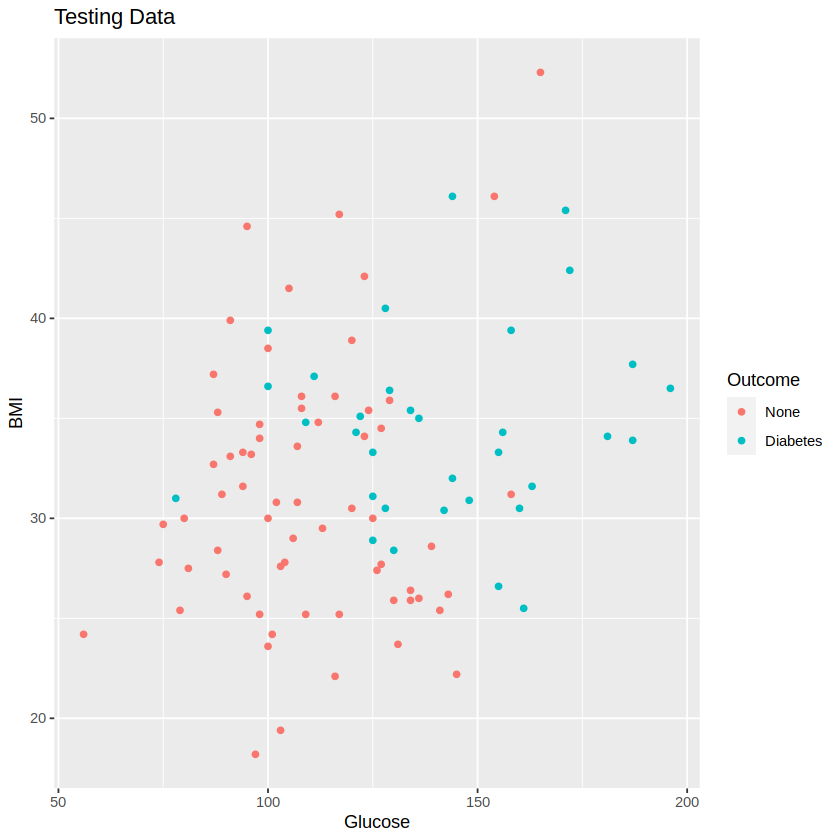

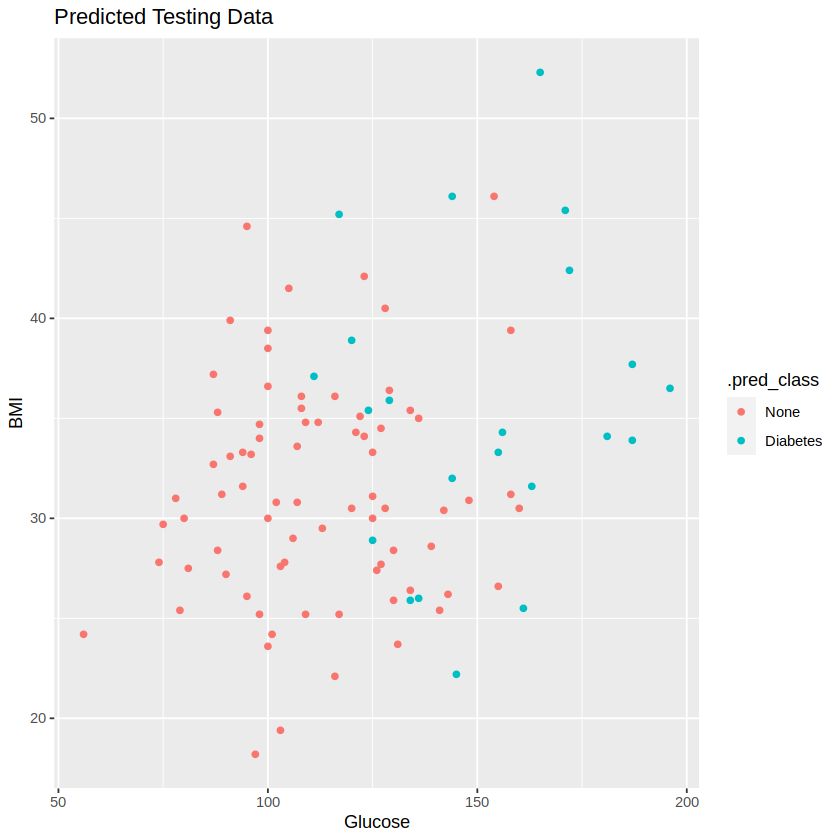

In [9]:
my_predictions <- diabetes_fit|>
  predict(diabetes_testing)|>
  bind_cols(diabetes_testing
           )
my_predictions %>%
        ggplot(aes(x = Glucose, y = BMI, color = Outcome ))+
        geom_point()+
        ggtitle("Testing Data")
my_predictions %>%
        ggplot(aes(x = Glucose, y = BMI, color = .pred_class ))+
        geom_point()+
        ggtitle("Predicted Testing Data")

In [10]:
my_prediction_accuracy <- my_predictions |>
         metrics(truth = Outcome, estimate = .pred_class) 

my_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7272727
kap,binary,0.3305785


In [11]:
diabetes_mat <- my_predictions |> 
       conf_mat(truth = Outcome, estimate = .pred_class)
diabetes_mat

          Truth
Prediction None Diabetes
  None       58       19
  Diabetes    8       14